## 1. Class별 개수

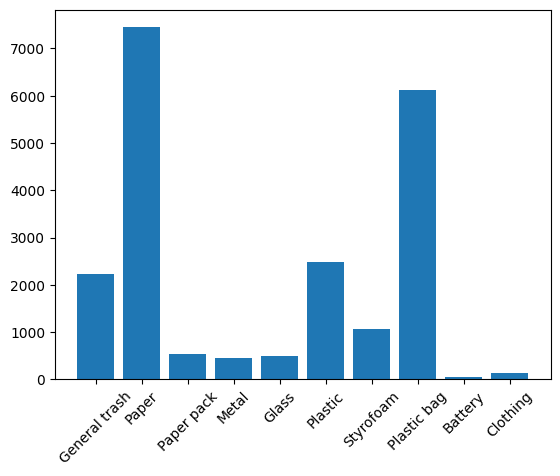

{'General trash': 2225, 'Paper': 7448, 'Paper pack': 527, 'Metal': 449, 'Glass': 488, 'Plastic': 2472, 'Styrofoam': 1074, 'Plastic bag': 6114, 'Battery': 50, 'Clothing': 141}


In [85]:
# Class별 개수 구하기
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

anno_path = '/opt/ml/input/data/train.json'
with open(anno_path) as f:
    anno = json.load(f)
cate_json = anno['categories']
anno_json = anno['annotations']

anno_pd = pd.DataFrame(anno_json)
anno_category = anno_pd['category_id']
anno_area = anno_pd['area']
anno_segmentation = anno_pd['segmentation']
anno_bbox = anno_pd['bbox']

counter_category = {cate_json[int(c)-1]['supercategory']:num for c, num in sorted(Counter(anno_category).items())}

names = list(counter_category.keys())
values = list(counter_category.values())

plt.bar(range(len(counter_category)), values, tick_label=names)
plt.xticks(rotation=45)
plt.show()
print(counter_category)

In [1]:
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import torch

anno_path = '/opt/ml/input/data/train.json'
with open(anno_path) as f:
    anno = json.load(f)
img_json = anno['images']
cate_json = anno['categories']
anno_json = anno['annotations']

image_pd = pd.DataFrame(img_json)
anno_pd = pd.DataFrame(anno_json)

def extract_category_image(category_id):
    image_id = anno_pd[anno_pd['category_id']==category_id]['image_id'].unique()
    image_name = {id:image_pd[image_pd['id']==id]['file_name'].item() for id in image_id}

    image_per_segmentation = {image_name[id]:[] for id in image_name}
    target = anno_pd[anno_pd['category_id']==category_id]
    for img_id, seg in zip(target['image_id'], target['segmentation']):
        image_per_segmentation[image_name[img_id]].extend(seg)
    
    return image_per_segmentation


battery_image_name = extract_category_image(9)
# cloth_image_name = extract_category_image(10)
list(battery_image_name.keys())


['batch_01_vt/0136.jpg',
 'batch_01_vt/0176.jpg',
 'batch_01_vt/0194.jpg',
 'batch_01_vt/0208.jpg',
 'batch_01_vt/0209.jpg',
 'batch_01_vt/0211.jpg',
 'batch_01_vt/0334.jpg',
 'batch_01_vt/0963.jpg',
 'batch_01_vt/1042.jpg',
 'batch_01_vt/1076.jpg',
 'batch_01_vt/1229.jpg',
 'batch_02_vt/1497.jpg',
 'batch_03/0048.jpg',
 'batch_03/0771.jpg',
 'batch_03/0838.jpg',
 'batch_03/0853.jpg',
 'batch_03/0863.jpg']

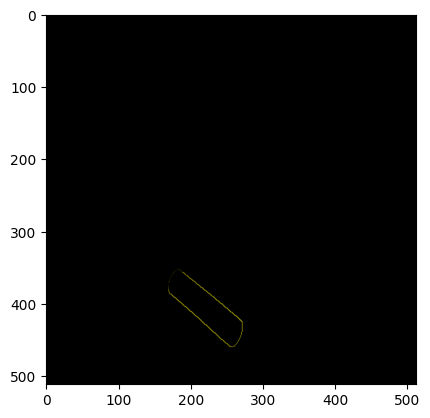

In [16]:
import torch
from PIL import Image
from torchvision.transforms import ToTensor

img = '/opt/ml/input/data/' + list(battery_image_name.keys())[0]
img = Image.open(img)
img = ToTensor()(img)

battery = torch.tensor(list(battery_image_name.values())[0][3])
battery = battery.reshape(-1, 2)

battery_img = torch.zeros(3, 512, 512)
for x, y in battery:
    battery_img[0][x][y] = img[0][x][y] 
    battery_img[1][x][y] = img[1][x][y] 
    # battery_img[2][x][y] = img[2][x][y] 

battery_img = battery_img.permute(1, 2, 0)
plt.imshow(battery_img)


loading annotations into memory...
Done (t=4.38s)
creating index...
index created!
{'license': 0, 'url': None, 'file_name': 'batch_03/0907.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2560}
{'license': 0, 'url': None, 'file_name': 'batch_03/0907.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2560}


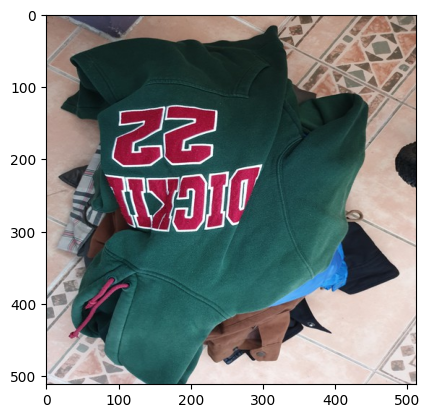

In [3]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2, os
import numpy as np
import random 

category_names = ['Background', 'General trash', 'Paper', 'Paper pack', 'Metal',
                'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"


coco = COCO('/opt/ml/input/data/train.json')

image_id = coco.getImgIds(catIds=10)
image_infos = coco.loadImgs(image_id)[0]
print(image_infos)

# cv2 를 활용하여 image 불러오기
images = cv2.imread(os.path.join('/opt/ml/input/data', image_infos['file_name']))
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
images /= 255.0

ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
anns = coco.loadAnns(ann_ids)

# Load the categories in a variable
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)

# masks : size가 (height x width)인 2D
# 각각의 pixel 값에는 "category id" 할당
# Background = 0
masks = np.zeros((image_infos["height"], image_infos["width"]))
# General trash = 1, ... , Cigarette = 10
anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
for i in range(len(anns)):
    className = get_classname(anns[i]['category_id'], cats)
    pixel_value = category_names.index(className)
    masks[coco.annToMask(anns[i]) == 1] = pixel_value
masks = masks.astype(np.int8)
                
# transform -> albumentations 라이브러리 활용
plt.imshow(images)
# plt.imshow(masks)
print(image_infos)

loading annotations into memory...
Done (t=4.47s)
creating index...
index created!
loading annotations into memory...
Done (t=4.16s)
creating index...
index created!


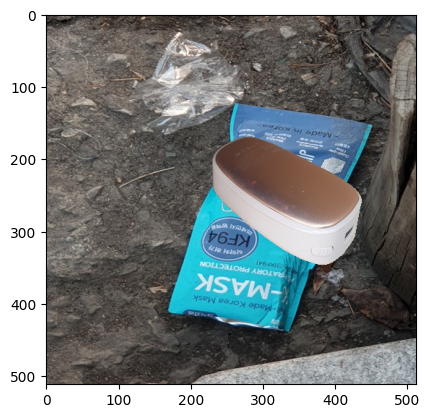

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from dataloaders.DataLoader import CustomDataLoader
from torch.utils.data import DataLoader
from utils.utils import copyblob
import torch
import time
from pycocotools.coco import COCO
import matplotlib.pyplot as plt


# -- augmentations
train_transform = A.Compose([
                        A.Resize(512, 512),
                        A.HorizontalFlip(p=0.5),
                        # A.Resize(256,256),
                        ToTensorV2()
                        ])

dataset_path = '/opt/ml/input/data'
# -- data_set
train_path = dataset_path + '/train.json'

train_dataset = CustomDataLoader(data_dir=train_path, dataset_path=dataset_path, mode='train', transform=train_transform)

# -- datalodaer
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(dataset=train_dataset, 
                            batch_size=4,
                            shuffle=True,
                            num_workers=4,
                            collate_fn=collate_fn,
                            drop_last=True)
coco = COCO(train_path)
for step, (images, masks, _) in enumerate(train_loader):
    images = torch.stack(images)
    masks = torch.stack(masks)

    p = 0.3
    for i in range(images.size()[0]):
        # class 9 --> class 0 
        copyblob(coco, transform=train_transform, dst_img=images[i], dst_mask=masks[i], src_class=9, dst_class=0, p=0.5)
        plt.imshow(images[i].permute(1, 2, 0))
        break
    break
    print(str(step) + '/' + str(len(train_loader)))

In [9]:
from pycocotools.coco import COCO
coco = COCO('/opt/ml/input/data/train.json')
category_names = ['Background', 'General trash', 'Paper', 'Paper pack', 'Metal',
                'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']

image_id = {category_names[i]:len(coco.getImgIds(catIds=i)) for i in range(1, 11)}

image_id

loading annotations into memory...
Done (t=4.17s)
creating index...
index created!


{'General trash': 1126,
 'Paper': 1406,
 'Paper pack': 330,
 'Metal': 250,
 'Glass': 168,
 'Plastic': 920,
 'Styrofoam': 435,
 'Plastic bag': 1489,
 'Battery': 17,
 'Clothing': 95}